# Undersea Cables

Dataset: https://www.kaggle.com/datasets/sndorburian/underwater-marine-data-cables/data 

## 1. Exploratory Data Analysis

In [1]:
# Initial Data Load

import json
import pandas as pd
from shapely import MultiLineString
import kagglehub

path = kagglehub.dataset_download("sndorburian/underwater-marine-data-cables")
data = json.load(open("../data/kaggle/underwatercable.json"))
df_undersea = pd.DataFrame(data["features"])
df_undersea.head()

,type,properties,geometry
0,Feature,"{'id': 'carnival-submarine-network-1-csn-1', '...","{'type': 'MultiLineString', 'coordinates': [[[..."
1,Feature,"{'id': 'sea-h2x', 'name': 'SEA-H2X', 'color': ...","{'type': 'MultiLineString', 'coordinates': [[[..."
2,Feature,"{'id': 'hronn', 'name': 'Hronn', 'color': '#00...","{'type': 'MultiLineString', 'coordinates': [[[..."
3,Feature,"{'id': 'cook-strait', 'name': 'Cook Strait', '...","{'type': 'MultiLineString', 'coordinates': [[[..."
4,Feature,"{'id': 'minoas-east-and-west', 'name': 'Minoas...","{'type': 'MultiLineString', 'coordinates': [[[..."


In [2]:
import geopandas as gpd

# Geo-enrichment of the data

gdf_undersea = df_undersea.copy(deep=False)

name_list = []
id_list = []
color_list = []

for i in df_undersea.index:
    name_i = df_undersea.loc[i].properties["name"]
    name_list.append(name_i)
    id_i = df_undersea.loc[i].properties["id"]
    id_list.append(id_i)
    color_i = df_undersea.loc[i].properties["color"]
    color_list.append(color_i)

gdf_undersea["id"] = id_list
gdf_undersea["name"] = name_list
gdf_undersea["color"] = color_list

geom_list = []
for i in df_undersea.index:
    geom_i = MultiLineString(pd.DataFrame(data["features"]).geometry.loc[i]["coordinates"])
    geom_list.append(geom_i)


gdf_undersea = gpd.GeoDataFrame(gdf_undersea, geometry = geom_list)
gdf_undersea = gdf_undersea.set_crs(4326)
gdf_undersea = gdf_undersea[["id", "name", "color", "properties", "geometry"]]
# gdf_undersea = gdf_undersea.drop_duplicates(subset=["id"]) # Drop duplicates - not yet
gdf_undersea.head()

,id,name,color,properties,geometry
0,carnival-submarine-network-1-csn-1,Carnival Submarine Network-1 (CSN-1),#939597,"{'id': 'carnival-submarine-network-1-csn-1', '...","MULTILINESTRING ((-79.53671 8.96483, -79.42487..."
1,sea-h2x,SEA-H2X,#939597,"{'id': 'sea-h2x', 'name': 'SEA-H2X', 'color': ...","MULTILINESTRING ((113.84999 17.10852, 116.9999..."
2,hronn,Hronn,#009f94,"{'id': 'hronn', 'name': 'Hronn', 'color': '#00...","MULTILINESTRING ((5.40007 55.3559, 5.28757 55...."
3,cook-strait,Cook Strait,#951f63,"{'id': 'cook-strait', 'name': 'Cook Strait', '...","MULTILINESTRING ((174.23597 -41.33903, 174.431..."
4,minoas-east-and-west,Minoas East and West,#939597,"{'id': 'minoas-east-and-west', 'name': 'Minoas...","MULTILINESTRING ((23.03575 36.52322, 23.28756 ..."


Additionally, we will also calculate the length of each cable, which will further serve as a proxy for the total **bandwith** of said cable when we program our quantum algorithm. Since we struggled finding fitting data specifying the bandwith of these cables, we decided upon a simple heuristic in which longer cables are expected to carry more bandwith. It is not bulletproof, we know, but it's the best we could come up with on the spot;)

In [3]:
gdf_undersea_measurement = gdf_undersea.copy(deep=False)
gdf_undersea_measurement = gdf_undersea_measurement.to_crs(3857)  # Set CRS to EPSG:3857 for measurement
gdf_undersea["bandwith"] = gdf_undersea_measurement["geometry"].apply(lambda x: x.length / 1000)  # Length in km
gdf_undersea.head()


,id,name,color,properties,geometry,bandwith
0,carnival-submarine-network-1-csn-1,Carnival Submarine Network-1 (CSN-1),#939597,"{'id': 'carnival-submarine-network-1-csn-1', '...","MULTILINESTRING ((-79.53671 8.96483, -79.42487...",4534.917302
1,sea-h2x,SEA-H2X,#939597,"{'id': 'sea-h2x', 'name': 'SEA-H2X', 'color': ...","MULTILINESTRING ((113.84999 17.10852, 116.9999...",5366.804446
2,hronn,Hronn,#009f94,"{'id': 'hronn', 'name': 'Hronn', 'color': '#00...","MULTILINESTRING ((5.40007 55.3559, 5.28757 55....",460.853735
3,cook-strait,Cook Strait,#951f63,"{'id': 'cook-strait', 'name': 'Cook Strait', '...","MULTILINESTRING ((174.23597 -41.33903, 174.431...",44.928948
4,minoas-east-and-west,Minoas East and West,#939597,"{'id': 'minoas-east-and-west', 'name': 'Minoas...","MULTILINESTRING ((23.03575 36.52322, 23.28756 ...",322.695477


Below, we plot the data using the freely available `natural_earth` geodataset (https://www.naturalearthdata.com/downloads/110m-cultural-vectors/)

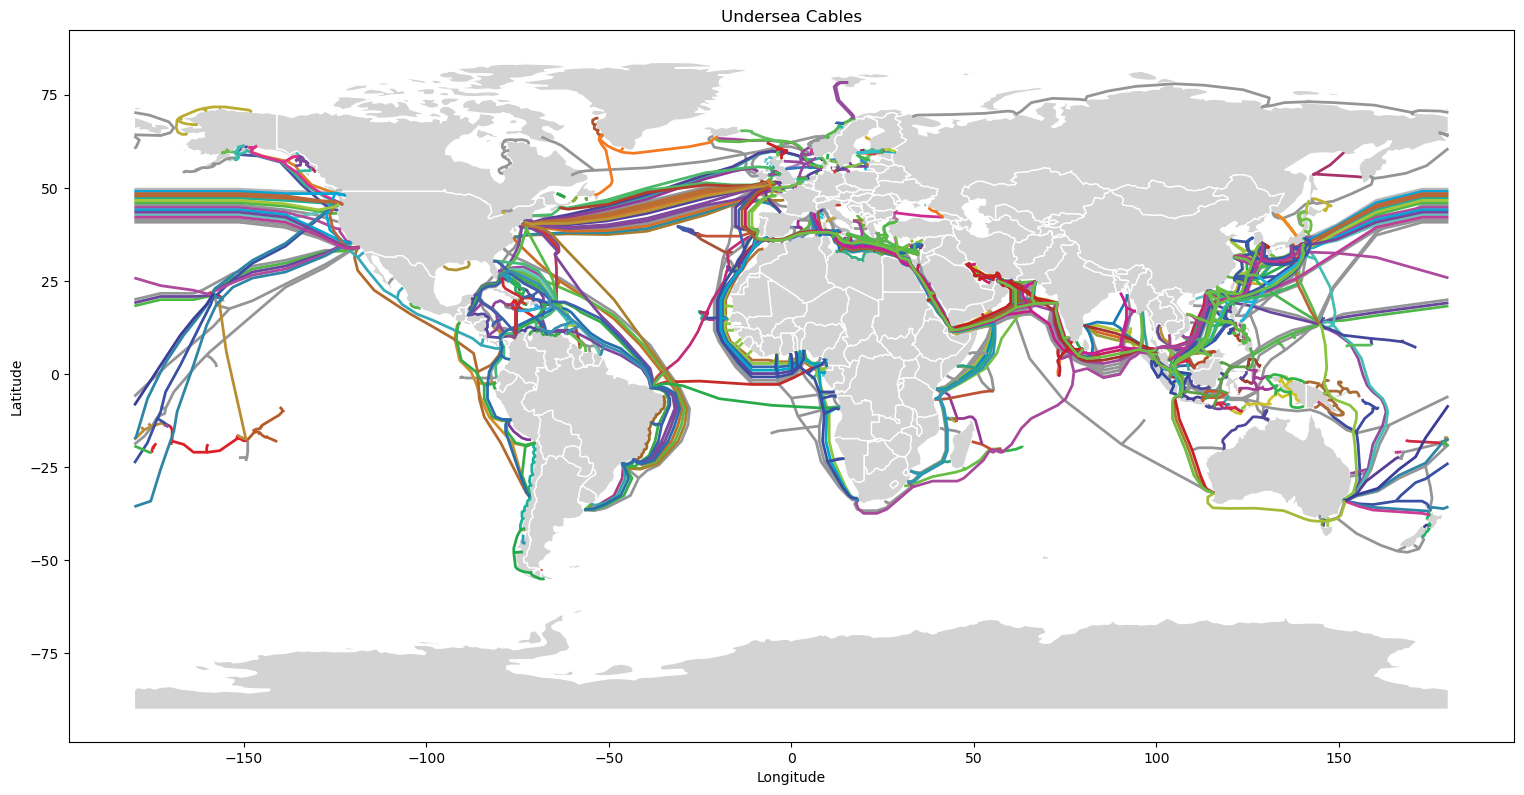

In [4]:
import matplotlib.pyplot as plt

# Download world shapefile for plotting
world = gpd.read_file("../data/map_data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")

fig, ax = plt.subplots(figsize=(16, 8))
world.plot(ax=ax, color='lightgray', edgecolor='white')

gdf_undersea.plot(ax=ax, color=gdf_undersea["color"], linewidth=2, legend=True)

plt.title("Undersea Cables")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.savefig("../undersea_cables_world.png", dpi=200) # Save to repo
plt.show()

If we zoom in, however, we find our first issue - the entries in the dataset are persisted using the `MultiLineString` format and therefore it can be problematic to try and represent them using standard measurements such as length or other statistics:

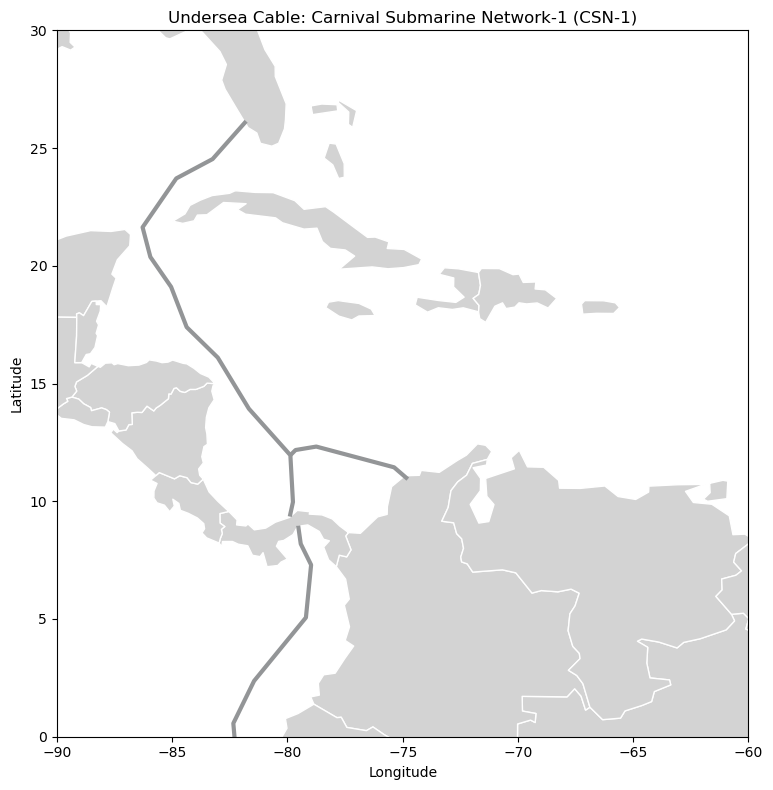

In [5]:
# Plot the first cable (Caribbean region)
fig, ax = plt.subplots(figsize=(10, 8))

# Plot world basemap
world = gpd.read_file("../data/map_data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
world.plot(ax=ax, color='lightgray', edgecolor='white')

# Plot the first cable
gdf_undersea.iloc[0:1].plot(ax=ax, color=gdf_undersea.iloc[0]["color"], linewidth=3)

plt.title(f"Undersea Cable: {gdf_undersea.iloc[0]['name']}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim(-90, -60)  # Adjust as needed for the Caribbean
plt.ylim(0, 30)
plt.tight_layout()
plt.show()

Additionally, we also look for duplicates in our dataset, realising that many of these are cables that are also Y-shaped and connect to each other. Therefore, we join them to ensure data consistency. Luckily, such cables only come in pairs.

After this, we also persist the `gdf_undersea` dataset for further analysis.

In [6]:
from shapely.geometry import MultiLineString

duplicate_ids = gdf_undersea[gdf_undersea.duplicated(subset=["id"], keep=False)]["id"].unique()
df_cables_doubled = gdf_undersea[gdf_undersea["id"].isin(duplicate_ids)].sort_values(by="id")

gdf_y = gpd.GeoDataFrame() # New DF

for i in duplicate_ids:
    df_x = df_cables_doubled[df_cables_doubled["id"] == i].copy() 
    if len(df_x) < 2:
        print(f"Skipping ID {i} due to insufficient entries.")
        continue
    joined_geoms = MultiLineString(list(df_x.geometry.iloc[0].geoms) + list(df_x.geometry.iloc[1].geoms))
    joined_bandwidth = df_x.bandwith.iloc[0] + df_x.bandwith.iloc[1]
    df_x = df_x.drop_duplicates(subset=["id"]).iloc[[0]]
    df_x["geometry"] = [joined_geoms] 
    df_x["bandwith"] = joined_bandwidth
    gdf_y = pd.concat([gdf_y, df_x], ignore_index=True)

# Add those entries back to the original GeoDataFrame
gdf_undersea = gdf_undersea[~gdf_undersea["id"].isin(duplicate_ids)]
gdf_undersea = pd.concat([gdf_undersea, gdf_y], ignore_index=True)
gdf_undersea.to_file("../data/gdf_undersea.geojson", driver="GeoJSON") # Persist file

gdf_y

,id,name,color,properties,geometry,bandwith
0,havfrueaec-2,Havfrue/AEC-2,#30aa9f,"{'id': 'havfrueaec-2', 'name': 'Havfrue/AEC-2'...","MULTILINESTRING ((7.99626 58.15107, 7.87507 57...",11541.848735
1,peace-cable,PEACE Cable,#0090c5,"{'id': 'peace-cable', 'name': 'PEACE Cable', '...","MULTILINESTRING ((37.91255 20.37504, 38.10005 ...",23281.918590
2,jupiter,JUPITER,#929497,"{'id': 'jupiter', 'name': 'JUPITER', 'color': ...","MULTILINESTRING ((141.97497 34.40502, 141.0749...",17425.560143
3,tannat,Tannat,#34a8a7,"{'id': 'tannat', 'name': 'Tannat', 'color': '#...","MULTILINESTRING ((-46.32806 -23.96184, -45.899...",2460.756682
4,globenet,GlobeNet,#7b489c,"{'id': 'globenet', 'name': 'GlobeNet', 'color'...","MULTILINESTRING ((-80.08893 26.35058, -79.6498...",23603.749361
5,pacific-light-cable-network-plcn,Pacific Light Cable Network (PLCN),#bc3e96,"{'id': 'pacific-light-cable-network-plcn', 'na...","MULTILINESTRING ((-118.41596 33.91992, -120.59...",15400.334950
6,pishgaman-oman-iran-poi-network,Pishgaman Oman Iran (POI) Network,#939597,"{'id': 'pishgaman-oman-iran-poi-network', 'nam...","MULTILINESTRING ((57.7973 25.68132, 57.95931 2...",632.059941


----

## 2. Graph Creation

In order to formulate our problem within the graph theory domain in order to run quantum algorithms on it, we need to do a number of operations:

1. Extract all points from each MultiLineString and represent each individual point as a node and the connection (`LineString`) between them as an edge to form the graph that will underpin our solution
2. For each node, however, we will also keep the `id` value of the undersea cable it belongs to as a foreign key relating it to the original master table of cables. 
3. We also keep the `start_node` and `end_node` of each edge.

In [7]:
from shapely.geometry import Point, LineString

nodes = []
edges = []

for idx, row in gdf_undersea.iterrows():
    geom = row.geometry
    cable_id = row.id
    # Handle both MultiLineString and LineString
    if geom.geom_type == "MultiLineString":
        lines = list(geom.geoms)
    elif geom.geom_type == "LineString":
        lines = [geom]
    else:
        continue

    for line in lines:
        coords = list(line.coords)
        # Add nodes
        for pt in coords:
            nodes.append({"cable_id": cable_id, "geometry": Point(pt)})
        # Add edges (between consecutive points)
        for i in range(len(coords) - 1):
            edge = LineString([coords[i], coords[i+1]])
            edges.append({"cable_id": cable_id, "geometry": edge})

# Remove duplicate nodes and assign unique node_id
gdf_nodes = gpd.GeoDataFrame(nodes).drop_duplicates(subset=["geometry"]).reset_index(drop=True)
gdf_nodes = gdf_nodes.set_crs(4326)
gdf_nodes["node_id"] = gdf_nodes.index

# Create a mapping from Point geometry to node_id
point_to_id = {pt.wkt: node_id for pt, node_id in zip(gdf_nodes.geometry, gdf_nodes.node_id)}

# Add start_node and end_node to the edge table
start_nodes = []
end_nodes = []

for line in edges:
    line_geom = line["geometry"]
    start_pt = Point(line_geom.coords[0])
    end_pt = Point(line_geom.coords[1])
    start_nodes.append(point_to_id[start_pt.wkt])
    end_nodes.append(point_to_id[end_pt.wkt])

gdf_edges = gpd.GeoDataFrame(edges)
gdf_edges = gdf_edges.set_crs(4326)
gdf_edges["start_node"] = start_nodes
gdf_edges["end_node"] = end_nodes

# Preview
print("Number of unique nodes:", gdf_nodes.shape[0], 
      "\nNumber of unique edges:", gdf_edges.shape[0])

Number of unique nodes: 9404 
Number of unique edges: 9747


Additionally, we also add the **bandwith** statistic from `gdf_undersea` and we calculate the length (**weight**) of every edge present in the dataset. We do this with the help of the EPSG 3857 metric representation.

In [8]:
# Add bandwith information to edges from undersea cables

gdf_edges = pd.merge(gdf_edges, gdf_undersea[["id", "bandwith"]], left_on="cable_id", right_on="id", how="left").drop("id", axis=1)

# Find the length of each undersea cable in kilometers

gdf_edge_measurement = gdf_edges.copy(deep=False)
gdf_edge_measurement = gdf_edge_measurement.to_crs(3857)  # Set CRS to EPSG:3857 for measurement
gdf_edge_measurement["weight"] = gdf_edge_measurement["geometry"].apply(lambda x: x.length / 1000)  # Length in km

# Add the length of each cable to the original GeoDataFrame
gdf_edges["weight"] = gdf_edge_measurement["weight"]

gdf_edges = gdf_edges.reset_index()
gdf_edges.columns = ["edge_id", "cable_id", "geometry", "start_node", "end_node", "bandwith", "weight"]
gdf_edges["edge_id"] = gdf_edges.edge_id.apply(lambda x: f"edge_{x:04d}")
gdf_edges["start_node"] = gdf_edges.start_node.apply(lambda x: f"node_{x:04d}")
gdf_edges["end_node"] = gdf_edges.end_node.apply(lambda x: f"node_{x:04d}")

gdf_edges.head()

,edge_id,cable_id,geometry,start_node,end_node,bandwith,weight
0,edge_0000,carnival-submarine-network-1-csn-1,"LINESTRING (-79.53671 8.96483, -79.42487 8.19054)",node_0000,node_0001,4534.917302,88.053051
1,edge_0001,carnival-submarine-network-1-csn-1,"LINESTRING (-79.42487 8.19054, -78.97487 7.29876)",node_0001,node_0002,4534.917302,112.012998
2,edge_0002,carnival-submarine-network-1-csn-1,"LINESTRING (-78.97487 7.29876, -79.19987 5.06199)",node_0002,node_0003,4534.917302,251.717905
3,edge_0003,carnival-submarine-network-1-csn-1,"LINESTRING (-79.19987 5.06199, -81.44987 2.36791)",node_0003,node_0004,4534.917302,391.244580
4,edge_0004,carnival-submarine-network-1-csn-1,"LINESTRING (-81.44987 2.36791, -82.34987 0.56858)",node_0004,node_0005,4534.917302,224.025995


In [9]:
gdf_nodes = gdf_nodes[["node_id", "cable_id", "geometry"]]
gdf_nodes["node_id"] = gdf_nodes.node_id.apply(lambda x: f"node_{x:04d}")

gdf_nodes.head()

,node_id,cable_id,geometry
0,node_0000,carnival-submarine-network-1-csn-1,POINT (-79.53671 8.96483)
1,node_0001,carnival-submarine-network-1-csn-1,POINT (-79.42487 8.19054)
2,node_0002,carnival-submarine-network-1-csn-1,POINT (-78.97487 7.29876)
3,node_0003,carnival-submarine-network-1-csn-1,POINT (-79.19987 5.06199)
4,node_0004,carnival-submarine-network-1-csn-1,POINT (-81.44987 2.36791)


However, we uncover another problem - some of the nodes are duplicated. Not in the orthodox sense of the word, however. They are duplicated geographically, in the sense that they are merely very close to each other. This poses a problem, as we need to be very careful to maintain edge functionality when removing said duplicate nodes. Below is an example of the city of Foraleza in Brazil, home to two incredibly close nodes:

In [10]:
gdf_nodes[(gdf_nodes["node_id"] == "node_3556") | (gdf_nodes["node_id"] == "node_3539")]

,node_id,cable_id,geometry
3539,node_3539,south-atlantic-inter-link-sail,POINT (-38.54297 -3.71874)
3556,node_3556,brusa,POINT (-38.54296 -3.71874)


We attempt to remove them and adjust the edges accordingly:

In [11]:
import numpy as np

# Set a threshold distance (e.g., 0.01 degrees)
threshold_distance = 0.01  # Distance threshold in degrees

# Calculate distance between nodes
node_coords = np.array([node.coords[0] for node in gdf_nodes.geometry])
node_ids = gdf_nodes['node_id'].values

# Function to check if two nodes are within the threshold distance
def are_nodes_close(node1, node2, threshold=threshold_distance):
    return node1.distance(node2) <= threshold

# Create a dictionary for node merging
merged_nodes = {}

# Loop through nodes to find close nodes and merge
for i, node1 in enumerate(gdf_nodes.geometry):
    for j, node2 in enumerate(gdf_nodes.geometry):
        if i < j and are_nodes_close(node1, node2):
            # Assign the same new merged node id to both nodes
            merged_nodes[node_ids[j]] = node_ids[i]

# Merge Nodes
    # Create the new merged node list based on merged_nodes mapping
merged_nodes_list = []

for node_id, row in gdf_nodes.iterrows():
    # Check if the node is part of the merge (i.e., if it has been merged)
    new_node_id = merged_nodes.get(row['node_id'], row['node_id'])  # If merged, use the new ID; else keep original ID
    
    # Add the merged node data (node_id and geometry) to the new node list
    merged_nodes_list.append({
        'node_id': new_node_id,
        'geometry': row['geometry']
    })

# Create a GeoDataFrame for the merged nodes
gdf_merged_nodes = gpd.GeoDataFrame(merged_nodes_list, crs=gdf_nodes.crs)

# Remove duplicates (in case multiple nodes merged into one)
gdf_merged_nodes = gdf_merged_nodes.drop_duplicates(subset=['node_id']).reset_index(drop=True)

# Update Edges Based on Merged Nodes
    # Function to update edges based on merged nodes
def update_edges_for_merged_nodes(edge, merged_nodes):
    start_node = edge['start_node']
    end_node = edge['end_node']

    # Update start and end node IDs based on the merged nodes mapping
    if start_node in merged_nodes:
        start_node = merged_nodes[start_node]
    if end_node in merged_nodes:
        end_node = merged_nodes[end_node]

    # Update edge geometry based on the new nodes
    start_point = gdf_merged_nodes[gdf_merged_nodes['node_id'] == start_node].geometry.iloc[0]
    end_point = gdf_merged_nodes[gdf_merged_nodes['node_id'] == end_node].geometry.iloc[0]
    
    updated_edge = LineString([start_point, end_point])
    
    return updated_edge, start_node, end_node

# Apply the update function to the edges
updated_edges = []

for idx, edge in gdf_edges.iterrows():
    updated_edge, start_node, end_node = update_edges_for_merged_nodes(edge, merged_nodes)
    updated_edges.append({
        'edge_id': edge['edge_id'],
        'start_node': start_node,
        'end_node': end_node,
        'geometry': updated_edge,
        'bandwith': edge['bandwith'], 
        'weight': edge['weight']
    })

# Convert the updated edges list back into a GeoDataFrame
gdf_updated_edges = gpd.GeoDataFrame(updated_edges, crs=gdf_edges.crs)

# Add back the cable_id to the updated edges
gdf_updated_edges = pd.merge(gdf_updated_edges, 
                             gdf_edges[["edge_id", "cable_id"]])[["edge_id", "cable_id", "geometry", "start_node", "end_node", "bandwith", "weight"]]

# Validate the Process
    # Final preview of merged nodes and updated edges
gdf_merged_nodes = pd.merge(gdf_merged_nodes, gdf_nodes, how="left") # Add back the cable_id
        # Note: The how="left" will make some 70 entries NaN, as they were not present in the original gdf_nodes.
gdf_merged_nodes.head()

,node_id,geometry,cable_id
0,node_0000,POINT (-79.53671 8.96483),carnival-submarine-network-1-csn-1
1,node_0001,POINT (-79.42487 8.19054),carnival-submarine-network-1-csn-1
2,node_0002,POINT (-78.97487 7.29876),carnival-submarine-network-1-csn-1
3,node_0003,POINT (-79.19987 5.06199),carnival-submarine-network-1-csn-1
4,node_0004,POINT (-81.44987 2.36791),carnival-submarine-network-1-csn-1


In [12]:
gdf_updated_edges.head()

,edge_id,cable_id,geometry,start_node,end_node,bandwith,weight
0,edge_0000,carnival-submarine-network-1-csn-1,"LINESTRING (-79.53671 8.96483, -79.42487 8.19054)",node_0000,node_0001,4534.917302,88.053051
1,edge_0001,carnival-submarine-network-1-csn-1,"LINESTRING (-79.42487 8.19054, -78.97487 7.29876)",node_0001,node_0002,4534.917302,112.012998
2,edge_0002,carnival-submarine-network-1-csn-1,"LINESTRING (-78.97487 7.29876, -79.19987 5.06199)",node_0002,node_0003,4534.917302,251.717905
3,edge_0003,carnival-submarine-network-1-csn-1,"LINESTRING (-79.19987 5.06199, -81.44987 2.36791)",node_0003,node_0004,4534.917302,391.244580
4,edge_0004,carnival-submarine-network-1-csn-1,"LINESTRING (-81.44987 2.36791, -82.34987 0.56858)",node_0004,node_0005,4534.917302,224.025995


In [13]:
# Persist data

# gdf_nodes.to_file("../data/gdf_nodes.geojson", driver="GeoJSON")
# gdf_edges.to_file("../data/gdf_edges.geojson", driver="GeoJSON")

gdf_merged_nodes.to_file("../data/gdf_nodes.geojson", driver="GeoJSON")
gdf_updated_edges.to_file("../data/gdf_edges.geojson", driver="GeoJSON")

Now, we are ready to represent our structure as a **graph**. We do this using the `networkx` library in Python.

In [14]:
import networkx as nx

# Create an undirected graph
G = nx.Graph()

# Add nodes with attributes 
for _, row in gdf_merged_nodes.iterrows():
    G.add_node(row["node_id"], cable_id=row["cable_id"], geometry=row["geometry"])

# Add edges using start_node and end_node
for _, row in gdf_updated_edges.iterrows():
    G.add_edge(row["start_node"], row["end_node"], cable_id=row["cable_id"], geometry=row["geometry"], edge_attr='weight')

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Graph has 9289 nodes and 9730 edges.


Now that we have such a graph, we can look at various statistics, such as querying the nodes with the highest degree centrality in the graph, i.e. most important nodes in the global undersea internet cable network.

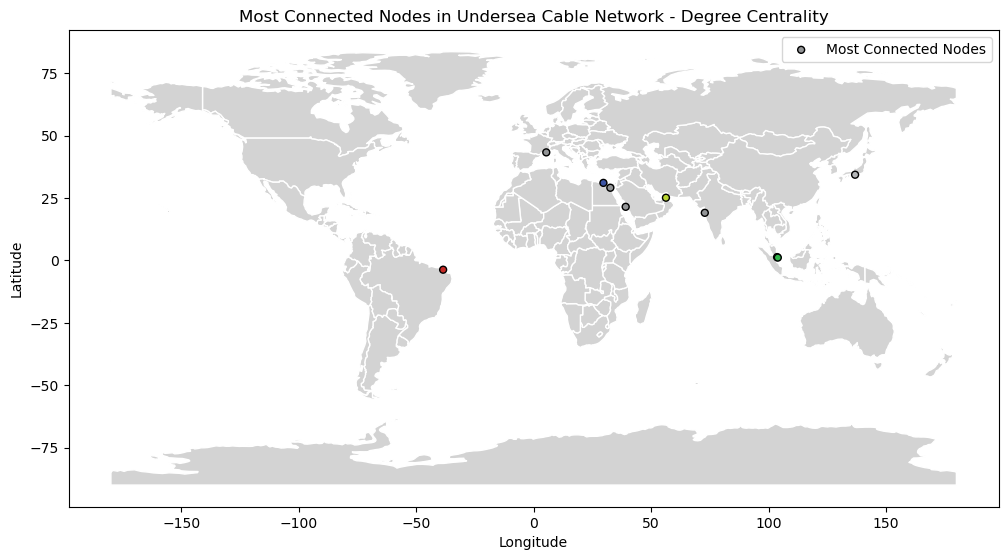

In [15]:
# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)
degree_centrality_ordered = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

top_n = 10
most_connected_nodes = [x[0] for x in degree_centrality_ordered[0:top_n]]
degree_centrality = [x[1] for x in degree_centrality_ordered[0:top_n]]

# Get the GeoDataFrame of the most connected nodes
top_nodes_gdf = gdf_merged_nodes[gdf_merged_nodes["node_id"].isin(most_connected_nodes)].copy()
# Merge with original gdf to get cable color

top_nodes_gdf = pd.merge(top_nodes_gdf, gdf_undersea[["id", "color"]], left_on="cable_id", right_on="id", how="left"
)[["node_id", "cable_id", "geometry", "color"]].head(top_n)

fig, ax = plt.subplots(figsize=(12, 8))

# Plot a world basemap (you might need to adjust the path)
world = gpd.read_file("../data/map_data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
world.plot(ax=ax, color="lightgray", edgecolor="white")
top_nodes_gdf.plot(ax=ax, color=top_nodes_gdf.color, edgecolor="black", markersize=25, label="Most Connected Nodes")
ax.set_title("Most Connected Nodes in Undersea Cable Network - Degree Centrality")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.show()


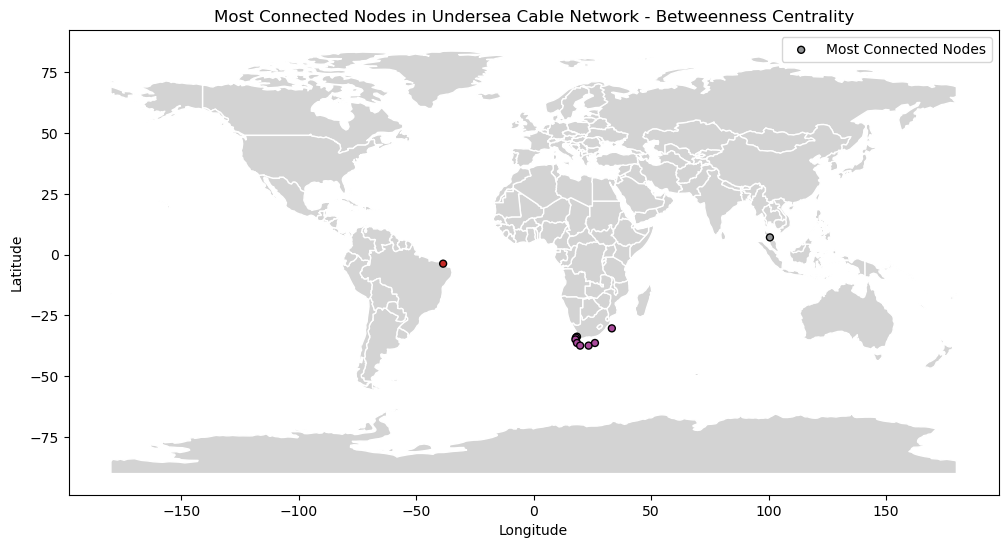

In [16]:
# Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)
betweenness_centrality_ordered = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)

top_n = 10
most_connected_nodes = [x[0] for x in betweenness_centrality_ordered[0:top_n]]
betweenness_centrality = [x[1] for x in betweenness_centrality_ordered[0:top_n]]

# Get the GeoDataFrame of the most connected nodes
top_nodes_gdf = gdf_merged_nodes[gdf_merged_nodes["node_id"].isin(most_connected_nodes)].copy()
# Merge with original gdf to get cable color

top_nodes_gdf = pd.merge(top_nodes_gdf, gdf_undersea[["id", "color"]], left_on="cable_id", right_on="id", how="left"
)[["node_id", "cable_id", "geometry", "color"]].head(top_n)

fig, ax = plt.subplots(figsize=(12, 8))

# Plot a world basemap (you might need to adjust the path)
world = gpd.read_file("../data/map_data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
world.plot(ax=ax, color="lightgray", edgecolor="white")
top_nodes_gdf.plot(ax=ax, color=top_nodes_gdf.color, edgecolor="black", markersize=25, label="Most Connected Nodes")
ax.set_title("Most Connected Nodes in Undersea Cable Network - Betweenness Centrality")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.show()


----

## 3. Max Flow Optimization

Now that we have created our graph and concluded our initial analysis, we can stipulate the first of our optimization objectives: finding the maximum amount of flow that can be pushed from a *source node* to a *sink node* in this network, while adhering to a capacity contraint (in this case, the bandwith, which we have calculated based on the total length of the cable each node belongs to and represents, we repeat, an arbitrary number...) on the edges. We stipulate our problem as such:

Each edge (segment of a submarine cable) $(u,v) \in E$ has a capacity $c(u,v)$, i.e., the maximum amount of data that can pass from node $u$ to node $v$ and vice-versa through this edge.

The flow $f(u,v)$, therefore, can not be higher than the overall edge capacity, expressed as:

$$

f(u,v) \leq c(u,v)

$$

### Objective: Maximize the Flow

Our objective is to **maximize** the flow from the **source node** $s$ to the **sink node** $t$, subject to the capacity constraints. In other words, we want to push as much data as possible from $s$ to $t$ while ensuring that no edge's flow exceeds its capacity.

### Constraints:
- **Flow Conservation**: At each intermediate node (except the source and sink), the total flow into the node must equal the total flow out of the node. Mathematically:

$$
\sum_{v \in V} f(u,v) = \sum_{v \in V} f(v,u) \quad \forall u \in V \setminus \{s,t\}
$$

- **Capacity Constraints**: For each edge $(u,v)$, the flow on that edge must respect the capacity of the cable:

$$
f(u,v) \leq c(u,v)
$$

- **Non-Negative Flow**: The flow on each edge must be non-negative:

$$
f(u,v) \geq 0 \quad \forall (u,v) \in E
$$

### Solving the Maximum Flow Problem

The problem can be solved using various algorithms, such as:

1. **Ford-Fulkerson Algorithm**: This algorithm repeatedly finds augmenting paths and increases the flow along those paths until no more augmenting paths can be found.
2. **Edmonds-Karp Algorithm**: This is an implementation of Ford-Fulkerson using **Breadth-First Search (BFS)** to find the shortest augmenting path.
3. **Push-Relabel Algorithm**: This algorithm uses node heights and pushes flow locally across edges, often providing better performance for dense graphs.

### Result: Maximum Flow

Once the maximum flow is found, it will represent the optimal way to push data from the source node $s$ to the sink node $t$, ensuring that all edge capacities are respected.

This is a crucial optimization problem in network design and is directly applicable to optimizing data flow across the undersea cable network, where each cable has a specific bandwidth limit.

Next, we will implement the **Maximum Flow** algorithm to find the optimal flow in our graph, using one of the classical optimization algorithms.

---

**Note:** We consulted the following documentation: https://developers.google.com/optimization/flow/maxflow and installed `ortools==9.11.4210`




In [ ]:
from ortools.graph.python import max_flow

# Instantiate a SimpleMaxFlow solver.
smf = max_flow.SimpleMaxFlow()

# OR Tools works slightly differently than NX, it logs start_nodes, end_nodes, and capacities for each edge.
    # Therefore, we use NumPy arrays to store the data from our original edge DataFrame.
start_nodes = np.array([int(i[5:]) for i in list(gdf_updated_edges["start_node"])] + [int(i[5:]) for i in list(gdf_updated_edges["end_node"])])
end_nodes = np.array([int(i[5:]) for i in list(gdf_updated_edges["end_node"])] + [int(i[5:]) for i in list(gdf_updated_edges["start_node"])])
capacities = np.array(list(gdf_updated_edges["bandwith"]) + list(gdf_updated_edges["bandwith"]))

# Note: We did something a bit stupidly simple here - since max flow requires a directed graph, we added each edge twice, once for each direction, with the same capacity.
# Therefore, we also create a bi-directional edge DataFrame.
gdf_updated_edges_flipped = gdf_updated_edges.copy(deep=False)
gdf_updated_edges_flipped["start_node"] = list(gdf_updated_edges["end_node"])
gdf_updated_edges_flipped["end_node"] = list(gdf_updated_edges["start_node"])
gdf_edges_bi = pd.concat([gdf_updated_edges, gdf_updated_edges_flipped], ignore_index=True)
gdf_edges_bi.to_file("../data/gdf_edges_bi.geojson", driver="GeoJSON") # persist bi-directional edges

# Add arcs (edges) in bulk:
all_arcs = smf.add_arcs_with_capacity(start_nodes, end_nodes, capacities)

Let's choose two random nodes, one in Long Beach, NY and the other in Singapore:

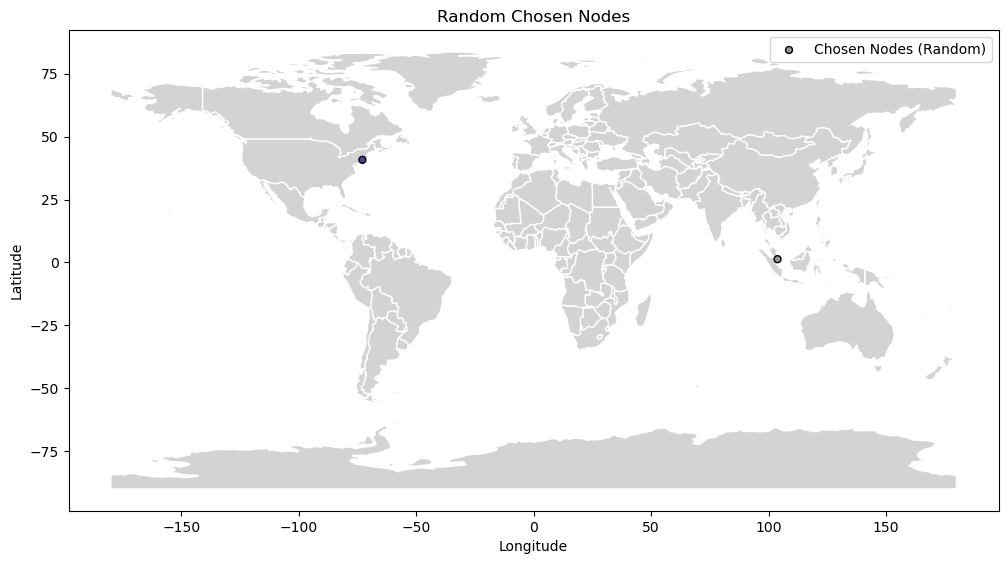

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))

random_nodes = gdf_merged_nodes[(gdf_merged_nodes["node_id"] == "node_4442") | (gdf_merged_nodes["node_id"] == "node_0208")]
random_nodes = pd.merge(random_nodes, gdf_undersea[["id", "color"]], left_on="cable_id", right_on="id", how="left"
)[["node_id", "cable_id", "geometry", "color"]]

# Plot a world basemap (you might need to adjust the path)
world = gpd.read_file("../data/map_data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
world.plot(ax=ax, color="lightgray", edgecolor="white")
random_nodes.plot(ax=ax, color=random_nodes.color, edgecolor="black", markersize=25, label="Chosen Nodes (Random)")
#plt.xlim(45, 110)  # Adjust as needed for the Caribbean
#plt.ylim(-5, 30)
ax.set_title("Random Chosen Nodes")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.show()

We calculate the max flow between them using `ortools` like so:

In [19]:
# Find the maximum flow between node 4442 and node 0208 (example nodes).

import itertools

def max_flow_solver(start_node, end_node):
    status = smf.solve(start_node, end_node)

    if status != smf.OPTIMAL:
        print("There was an issue with the max flow input.")
        print(f"Status: {status}")
        exit(1)
    print("Max flow:", smf.optimal_flow())
    print("")
    print(" Arc    Flow / Capacity")
    solution_flows = smf.flows(all_arcs)
    # Print first 10 arcs using enumerate to limit iterations
    for index, (arc, flow, capacity) in enumerate(zip(all_arcs, solution_flows, capacities)):
        if index >= 10:
            break
        print(f"{smf.tail(arc)} / {smf.head(arc)}   {flow:3}  / {capacity:3}")
    print("... and so on for all arcs ...")
    print("Source side min-cut:", smf.get_source_side_min_cut()[0:10], "... and so on")
    print("Sink side min-cut:", smf.get_sink_side_min_cut()[0:10], "... and so on")

    # Create an edge dataFrame with the results
    df_arcs = pd.DataFrame(columns=["start_node", "end_node", "flow", "capacity"])
    df_arcs["start_node"] = [f"node_{smf.tail(arc):04d}" for arc in all_arcs]
    df_arcs["end_node"] = [f"node_{smf.head(arc):04d}" for arc in all_arcs]
    df_arcs["flow"] = solution_flows
    df_arcs["capacity"] = capacities
    df_arcs = df_arcs[df_arcs.flow > 0] # Filter edges with no flow

    # Now, we merge the arcs with the original edges to get the geometry and cable_id information.
    # First, however, we remove the entries where our decided start node is the end node and vice versa, as these are not valid arcs (as we want to prevent loops)
    gdf_edges_bi_filtered = gdf_edges_bi[(gdf_edges_bi["start_node"] != end_node) & (gdf_edges_bi["end_node"] != start_node)]
    df_arcs = pd.merge(df_arcs, gdf_edges_bi_filtered[["start_node", "end_node", "edge_id", "cable_id", "geometry"]], on=["start_node", "end_node"], how="left") # Join edges
    gdf_arcs = gpd.GeoDataFrame(df_arcs, geometry="geometry", crs=gdf_edges_bi.crs) # Turn the DataFrame into a GeoDataFrame

    return gdf_arcs, smf.optimal_flow() # Return the GeoDataFrame of arcs, the valid combos and the maximum flow value

In [20]:
df_ny, ny_max_flow = max_flow_solver(4442, 208) # (310, 3539) for Portugal

Max flow: 20274

 Arc    Flow / Capacity
0 / 1     0  / 4534.917302116375
1 / 2     0  / 4534.917302116375
2 / 3     0  / 4534.917302116375
3 / 4     0  / 4534.917302116375
4 / 5     0  / 4534.917302116375
5 / 6     0  / 4534.917302116375
6 / 7     0  / 4534.917302116375
7 / 8     0  / 4534.917302116375
9 / 10     0  / 4534.917302116375
10 / 11     0  / 4534.917302116375
... and so on for all arcs ...
Source side min-cut: [4442, 4443, 4468, 4444, 4467, 4445, 4466, 4446, 4465, 4447] ... and so on
Sink side min-cut: [208, 209, 232, 348, 879, 3435, 210, 233, 246, 234] ... and so on


The DataFrame we extracted will contain all the non-zero flow paths between the two selected nodes:

In [21]:
df_ny.head()

,start_node,end_node,flow,capacity,edge_id,cable_id,geometry
0,node_0146,node_0147,1996,20458.464628,edge_0141,seamewe-6,"LINESTRING (32.28445 31.25928, 32.06255 30.83702)"
1,node_0147,node_0148,1996,20458.464628,edge_0142,seamewe-6,"LINESTRING (32.06255 30.83702, 32.06255 30.07739)"
2,node_0148,node_0149,1996,20458.464628,edge_0143,seamewe-6,"LINESTRING (32.06255 30.07739, 32.28755 29.08273)"
3,node_0149,node_0108,1996,20458.464628,edge_0144,seamewe-6,"LINESTRING (32.28755 29.08273, 33.08277 28.36594)"
4,node_0307,node_0311,1996,8041.085595,edge_0293,medusa-submarine-cable-system,"LINESTRING (-9.44992 38.12273, -9.67492 37.23235)"


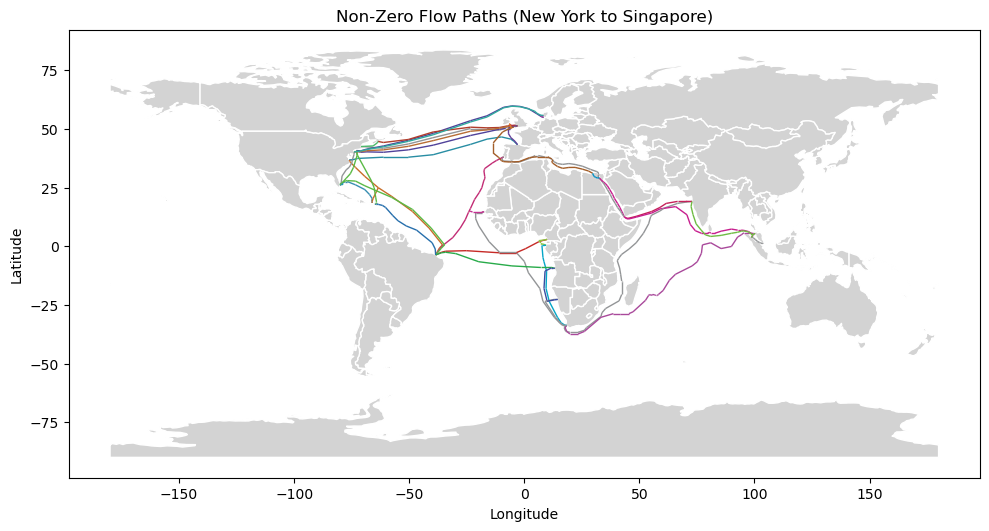

In [22]:
# Plot the non-zero flow paths
fig, ax = plt.subplots(figsize=(10, 8))

# Plot world basemap
world = gpd.read_file("../data/map_data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
world.plot(ax=ax, color='lightgray', edgecolor='white')

# Plot the flows
df_ny_plot = pd.merge(df_ny, gdf_undersea[["id", "color"]], left_on="cable_id", right_on="id", how="left").drop("id", axis=1)
df_ny_plot.plot(ax=ax, color = df_ny_plot["color"], linewidth=1)

plt.title(f"Non-Zero Flow Paths (New York to Singapore)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

And thus, we can further inspect how the algorithm functions: As we see, 4 cables exit New York - adding up to a total capacity of 20274, which happens to be our maximum flow result. The cable entering Singapore even has a slightly larger capacity, but this number represents the maximum amount of data that can be transferred between these two nodes on the network.

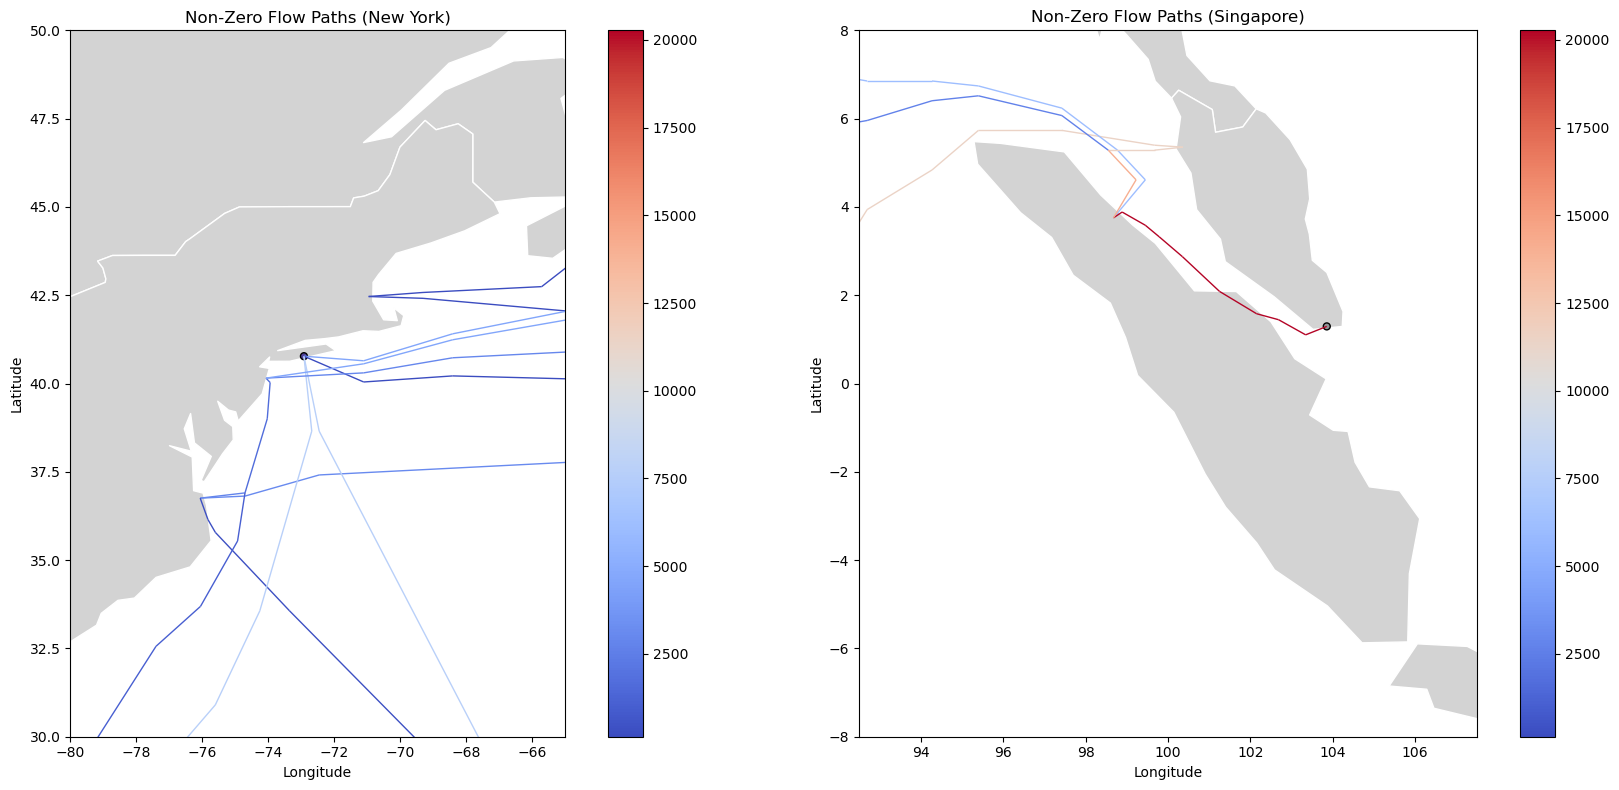

In [23]:
from matplotlib import cm
from matplotlib.colors import Normalize

# Read world shapefile
world = gpd.read_file("../data/map_data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")

# Create a subplot with two axes
fig, (ax_ny, ax_sg) = plt.subplots(1, 2, figsize=(18, 8))

# Plot the world basemap on both axes
world.plot(ax=ax_ny, color='lightgray', edgecolor='white')
world.plot(ax=ax_sg, color='lightgray', edgecolor='white')

# Normalize the flow values
norm = Normalize(vmin=df_ny_plot["flow"].min(), vmax=df_ny_plot["flow"].max())
cmap = cm.coolwarm  # Colormap to use for flows

# Zoom around New York 
ax_ny.set_xlim(-80, -65)  # Longitude range for New York
ax_ny.set_ylim(30, 50)  # Latitude range for New York

# Plot the flow data for New York on the first axis
df_ny_plot.plot(ax=ax_ny, column="flow", cmap=cmap, linewidth=1, legend=True, norm=norm)
random_nodes.plot(ax=ax_ny, color=random_nodes.color, edgecolor="black", markersize=25, label="Chosen Nodes (Random)")
ax_ny.set_title(f"Non-Zero Flow Paths (New York)")
ax_ny.set_xlabel("Longitude")
ax_ny.set_ylabel("Latitude")

# Zoom around Singapore
ax_sg.set_xlim(92.5, 107.5)  # Longitude range for Singapore
ax_sg.set_ylim(-8, 8)  # Latitude range for Singapore

# Plot the flow data for Singapore on the second axis
df_ny_plot.plot(ax=ax_sg, column="flow", cmap=cmap, linewidth=1, legend=True, norm=norm)
random_nodes.plot(ax=ax_sg, color=random_nodes.color, edgecolor="black", markersize=25, label="Chosen Nodes (Random)")
ax_sg.set_title(f"Non-Zero Flow Paths (Singapore)")
ax_sg.set_xlabel("Longitude")
ax_sg.set_ylabel("Latitude")

# Add a tight layout
plt.tight_layout()
plt.show()